# Understanding galaxy star formation rate estimates using radio luminosities

The star formation rate (SFR) of a galaxy is a fundamental property describing its current degree of activity and (together with its stellar mass) its current evolutionary state. There are, however, many different ways to estimate galaxy star formation rates, and all suffer from various limitations. Radio luminosity is potentially a unique tracer for this key property, presuming that any contribution from an active galactic nucleus (AGN) can be excluded, due to its direct link to the high-mass stellar population. In this project we will use data from EMU early science observations and the GAMA survey, in the G23 field. After excluding AGN systems through standard emission line diagnostics, we will explore a suite of common SFR estimators, and compare these against a selection of published radio SFR estimators, newly calculated for the EMU/GAMA data. We will also use the population synthesis tool, ProSpect, to provide independent SFR estimates (without relying on the radio data), as a step toward synthesising all available photometry in inferring SFRs. We will, finally, use ProSpect again to incorporate the radio measurements explicitly to derive refined SFRs, and use these directly to assess the reliabiility and robustness of any SFR estimates based on radio luminosity in isolation. A stretch goal for this project will be to link the SFRs and stellar masses for this sample to explore the “galaxy main sequence” of SFR as a function of stellar mass, and how it evolves over the redshift range spanned by the GAMA measurements.

## Load in Packages

In [1]:
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u

In [2]:
import matplotlib.colors as colors
from matplotlib import path
try:
    from astropy.convolution import Gaussian2DKernel, convolve
    astro_smooth = True
except ImportError as IE:
    astro_smooth = False

## Load in Data

In [4]:
cd \Project_AHopkins\Data

[WinError 3] The system cannot find the path specified: '\\Project_AHopkins\\Data'
E:\


### EMU Data

In [6]:
EMU_G23=fits.open('G23-ASKAP-EMUES-master-cat.fits')

In [7]:
EMU_G23.info()

Filename: G23-ASKAP-EMUES-master-cat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (1986,)   uint8   
  1  Joined        1 BinTableHDU     69   39812R x 27C   [19A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, A, D, K, D, D]   


In [8]:
EMU_data=Table(EMU_G23[1].data)
#EMU_data

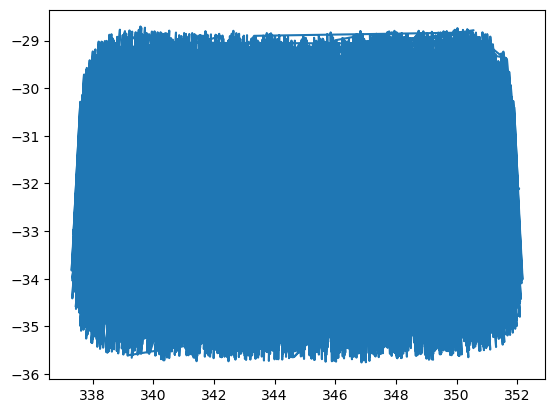

In [10]:
plt.plot(EMU_data['RA'], EMU_data['DEC'])

### GAMA

In [17]:
GFit=fits.open('GaussFitSimplev05.fits')
gkv=fits.open('gkvScienceCatv02.fits')
SMasses=fits.open('StellarMassesGKVv24.fits')

In [18]:
# GFit.info()
# gkv.info()
# SMasses.info()

In [19]:
GFit_data=Table(GFit[1].data)
#GFit_data

In [21]:
gkv_data=Table(gkv[1].data)
#gkv_data

In [24]:
SMasses_data=Table(SMasses[1].data)
#SMasses_data

In [25]:
SMasses_pd=SMasses_data.to_pandas()
gkv_pd=gkv_data.to_pandas()
GFit_pd=GFit_data.to_pandas()
EMU_pd=EMU_data.to_pandas()

#SMasses_pd

In [26]:
SMasses_pd.loc[:,"uberID"]

0         174001148708942
1         174001129809205
2         174001086008788
3         174001084207633
4         174001048108112
               ...       
370111    133000496408411
370112    176000226808518
370113    220000351709169
370114    178010820103143
370115    181010372002164
Name: uberID, Length: 370116, dtype: int64

In [27]:
GFit_pd=GFit_pd[GFit_pd.HA_FLUX >0]
#GFit_pd

In [29]:
GFit_pd=GFit_pd[GFit_pd.HB_FLUX >0]
#GFit_pd

## Cross Matching

### Join GAMA tables

##### gkv + SMasses

In [33]:
gkv_smasses = pd.merge(SMasses_pd, gkv_pd, on="uberID") 
#gkv_smasses

In [34]:
pd.set_option('display.max_columns', gkv_smasses.shape[0]+1)

##### gkv_smasses + GFit

In [45]:
# range=5/3600
# merged_data=[]
# for index1, row1 in gkv_smasses.iterrows():
#     for index2, row2 in GFit_pd.iterrows():
#         if np.absolute(row1['RAcen'] - row2['RA']) <= range:
#             merged_data.append({**row1, **row2})
# merged_df_loop = pd.DataFrame(merged_data)


In [47]:
# range=5/3600
# no=0
# merged_data=[]
# for index1, row1 in EMU_pd.iterrows():
#     for index2, row2 in gkv_smasses.iterrows():
#         dRA=np.absolute(row1['RA'] - row2['RAcen'])*np.cos(row1['DEC'])
#         ddec=np.absolute(row1['DEC'] - row2['Deccen'])
#         sep=np.sqrt((dRA**2)+(ddec**2))
#         if sep <= range:
#             merged_data.append({**row1, **row2})
#             no=no+1
#             print('sucess', no)
# merged_df_loop = pd.DataFrame(merged_data)


In [48]:
merged_df_loop

NameError: name 'merged_df_loop' is not defined

### Join GAMA and EMU tables 

In [55]:
EMU_GAMA=fits.open('\Cross_matching\EMU_GAMA_fits', ignore_missing_simple=True)
EMU_GAMA=Table(EMU_GAMA[1].data)
EMU_GAMA_pd=EMU_GAMA.to_pandas()
#EMU_GAMA_pd

## Data Reduction

In [58]:
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd.HA_FLUX >0]
EMU_GAMA_pd=EMU_GAMA_pd[EMU_GAMA_pd.HB_FLUX >0]
#EMU_GAMA_pd

In [60]:
#Signal to noise
EMU_GAMA_pd=EMU_GAMA_pd[(EMU_GAMA_pd.HA_FLUX/EMU_GAMA_pd.HA_FLUX_ERR) >3]
EMU_GAMA_pd=EMU_GAMA_pd[(EMU_GAMA_pd.HB_FLUX/EMU_GAMA_pd.HB_FLUX_ERR) >3]
#EMU_GAMA_pd

In [114]:
EMU_GAMA=Table.from_pandas(EMU_GAMA_pd)
#EMU_GAMA.write('EMU_GAMA_reduced.fits')

## BPT Diagnostics

add kewley and kauffmann lines 

kauffmann log(OIII/HB) = 1.3 + 0.61/(log(NII/HA)-0.05)

kewely log(OIII/HB) = (0.61/(log(NII/HA) -0.47))+ 1.19 

In [181]:
HB=EMU_GAMA_pd['HB_FLUX']
HA=EMU_GAMA_pd['HA_FLUX']
NII=EMU_GAMA_pd['NIIR_FLUX']
OIII=EMU_GAMA_pd['OIIIR_FLUX']

x=np.log10(NII/HA)
y=np.log10(OIII/HB)

C:\Users\jayde\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [583]:
x=np.array(x)
x[:]

array([-0.3704116 , -0.3675569 , -0.00425612, ..., -0.4643313 ,
       -0.34816486, -0.29413348], dtype=float32)

In [605]:
EMU_GAMA_pd.insert(2, "log(NII/Ha)", x[:])
EMU_GAMA_pd.insert(3, "log(OIII/HB)", y[:])

Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

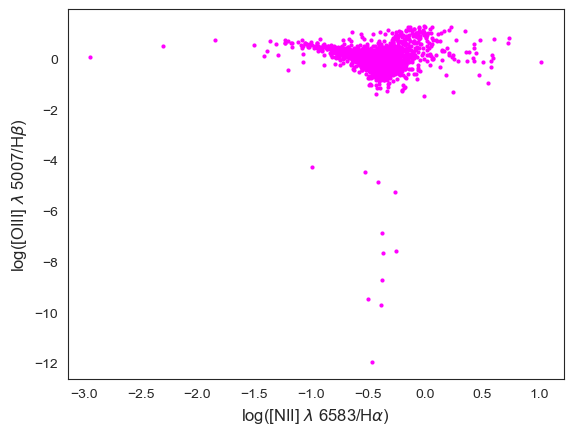

In [1094]:
Nsize = 12
fig, ax = plt.subplots()
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta')
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

In [120]:
x1=np.log10(np.arange(-50, 1, 0.01))
x2=np.log10(np.arange(-50, 2.5, 0.01))
y1=1.3 + 0.61/(x1-0.05) #kauffmann
y2=(0.61/(x2 -0.47))+1.19  #kewely

C:\Users\jayde\AppData\Local\Temp\ipykernel_4416\3782894524.py:1: RuntimeWarning: invalid value encountered in log10
  x1=np.log10(np.arange(-50, 1, 0.01))
C:\Users\jayde\AppData\Local\Temp\ipykernel_4416\3782894524.py:2: RuntimeWarning: invalid value encountered in log10
  x2=np.log10(np.arange(-50, 2.5, 0.01))


Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

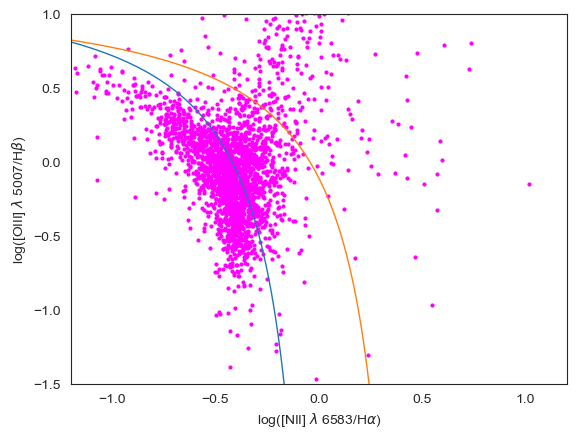

In [611]:

fig, ax = plt.subplots()
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta')
plt.plot(x1,y1)
plt.plot(x2, y2)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.5,1)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

In [613]:

H, xedges, yedges = np.histogram2d(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'],range=[[-1.3,1.3],[-1.5,1.1]], bins=60)
xmesh, ymesh = np.meshgrid(xedges[:-1], yedges[:-1])
if astro_smooth:
    kernel = Gaussian2DKernel(x_stddev=1)
    H=convolve(H,kernel)


Text(0, 0.5, 'log([OIII] $\\lambda$ 5007/H$\\beta$)')

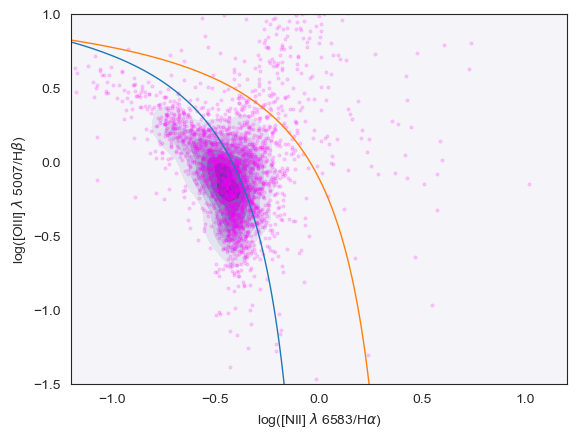

In [619]:
fig, ax = plt.subplots()
clevels = ax.contourf(xmesh,ymesh,H.T, cmap='Purples')
plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='magenta', alpha=0.15)
plt.plot(x1,y1, label='Kaufmann')
plt.plot(x2, y2)
ax.set_xlim(-1.2,1.2)
ax.set_ylim(-1.5,1)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=Nsize)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=Nsize)

## 

In [533]:
kauf = (y<1.3 + 0.61/(x-0.05))
#kew=(0.61/(x -0.47))+1.19  #kewely
ky=y[kauf]
kaufy=ky[x<0]
kx=x[kauf]
kaufx=kx[x<0]
kaufmann_points=np.array((kaufx, kaufy))
kaufmann_points

array([[-0.3704116 , -0.3675569 , -0.33328208, ..., -0.6461292 ,
        -0.61938334, -0.43120158],
       [-0.2200834 , -0.5808755 , -0.73367107, ..., -0.16594817,
         0.03277835, -0.5198508 ]], dtype=float32)

In [631]:
#plt.plot(kaufmann_points[0],kaufmann_points[1])

In [535]:
kaufmann_points.write('Sample1.fits')

AttributeError: 'numpy.ndarray' object has no attribute 'write'

In [551]:
kkkk= {'log([NII]/HA)': kaufmann_points[0], 'log([OIII]/HB)': kaufmann_points[1]}

### Creating Sample1

In [847]:
sample1=EMU_GAMA_pd[EMU_GAMA_pd['log(OIII/HB)']<1.3 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.05)]

In [849]:
sample1=sample1[sample1['log(NII/Ha)']<0]

In [757]:
#plt.scatter(sample1['log(NII/Ha)'], sample1['log(OIII/HB)'])

In [711]:
#from astropy.table import Table
t=Table.from_pandas(sample1)

In [721]:
t.write('E:\sample1.fits')

### Creating Sample2

In [857]:
sample2=EMU_GAMA_pd[EMU_GAMA_pd['log(OIII/HB)']>1.3 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.05)]

In [859]:
#(0.61/(x -0.47))+1.19
sample2=sample2[sample2['log(OIII/HB)']<1.19 + 0.61/(sample2['log(NII/Ha)']-0.47)]

In [753]:
#plt.scatter(sample2['log(NII/Ha)'], sample2['log(OIII/HB)'])

In [755]:
samp2=Table.from_pandas(sample2)
samp2.write('E:\sample2.fits')

### Creating Sample3

In [921]:
mask1= (EMU_GAMA_pd['log(OIII/HB)']>1.19 + 0.61/(EMU_GAMA_pd['log(NII/Ha)']-0.47))
mask2= (EMU_GAMA_pd['log(NII/Ha)']>0.1)


In [923]:
sample3=EMU_GAMA_pd[mask1 | mask2]

In [929]:
#plt.scatter(sample3['log(NII/Ha)'], sample3['log(OIII/HB)'])

In [931]:
samp3=Table.from_pandas(sample3)
samp3.write('E:\sample3.fits')

### Return to BPT

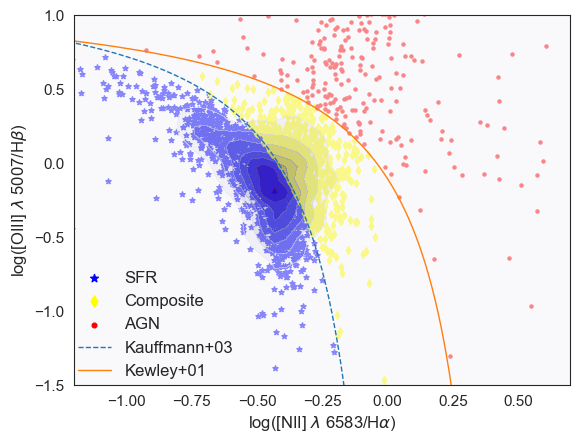

In [1092]:
fig, ax = plt.subplots()

plt.scatter(sample1['log(NII/Ha)'], sample1['log(OIII/HB)'], color='blue', marker='*', sizes=[15], label='SFR')
plt.scatter(sample2['log(NII/Ha)'], sample2['log(OIII/HB)'], color='yellow',marker='d', sizes=[15], label='Composite')
plt.scatter(sample3['log(NII/Ha)'], sample3['log(OIII/HB)'], color='red', marker='.',sizes=[20], label='AGN')


#plt.scatter(EMU_GAMA_pd['log(NII/Ha)'],EMU_GAMA_pd['log(OIII/HB)'], marker=".", color='black')
clevels = ax.contourf(xmesh,ymesh,H.T, cmap='Purples',alpha=0.55)

plt.plot(x1,y1, linestyle='dashed', label='Kauffmann+03')
plt.plot(x2, y2, label='Kewley+01' )
ax.set_xlim(-1.2,0.7)
ax.set_ylim(-1.5,1)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
ax.legend(loc='upper right', bbox_to_anchor=(0.35, 0.35), fontsize=12, markerscale=1.5, shadow=True)
ax.set_xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)',fontsize=12)
ax.set_ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=12)
#plt.scatter(kaufmann_points[0],kaufmann_points[1], marker="*", alpha=0.3)
plt.savefig('E:\\BPT.png')

## Radio Flux to SFR

## Hα Flux to SFR